In [1]:
import os
import scipy.io
import pandas as pd
import cv2
from PIL import Image
import random
import shutil
from IPython.display import clear_output

# Convertir numpy array en una lista para cada fila


def get_rows(img_names, labels):
    rows = []
    for index, img_name in enumerate(img_names): # enumerate(img_names) -> iterador con estructura (indice, array(['nombre_imagen.jpg']))
        for label in labels[index]:
            row = [img_name.item()]
            row.extend(label)  # concatena las etiquetas
            rows.append(row)
    return rows

# Convierte el archivo LabelTrainAll.mat en un DataFrame de pandas
def make_train_data():
    '''
    readme-train.txt

    MAFA training set
    1) images folder puts the 25876 image files; 
    2) the label is stored in LabelTrainAll.mat,
    3) the format is stored in a 18d array (x,y,w,h, x1,y1,x2,y2, x3,y3,w3,h3, occ_type, occ_degree, gender, race, orientation, x4,y4,w4,h4),  where        
        (a) (x,y,w,h) is the bounding box of a face, 
        (b) (x1,y1,x2,y2) is the position of two eyes.
        (c) (x3,y3,w3,h3) is the bounding box of the occluder. Note that (x3,y3) is related to the face bounding box position (x,y)
        (d) occ_type stands for the occluder type and has: 1 for simple, 2 for complex and 3 for human body.
        (e) occ_degree stands for the number of occluded face parts
        (f) gender and race stand for the gender and race of one face
        (g) orientation stands for the face orientation/pose, and has: 1-left, 2-left frontal, 3-frontal, 4-right frontal, 5-right
        (h) (x4,y4,w4,h4) is the bounding box of the glasses and is set to (-1,-1,-1,-1) when no glasses.  Note that (x4,y4) is related to the face bounding box position (x,y)

    If any question, please contact me. (geshiming@iie.ac.cn)
    '''

    # dictionary with variable names as keys, and loaded matrices as values.
    train = scipy.io.loadmat('LabelTrainAll.mat')
    # print(train.keys()) # dict_keys(['__header__', '__version__', '__globals__', 'label_train'])
    train_labels = train['label_train'][0]  # array de (25876,) elementos
    img_names = train_labels['imgName']
    labels = train_labels['label']  # 21 labels
    column_name = ['image_name', 'x', 'y', 'w', 'h', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'w3',
                   'h3', 'occ_type', 'occ_degree', 'gender', 'race', 'orientation', 'x4', 'y4', 'w4', 'h4']
    rows = get_rows(img_names, labels)
    return pd.DataFrame(data=rows, columns=column_name)

# Convierte el archivo LabelTestAll.mat en un DataFrame de pandas


def make_test_data():
    '''
        MAFA-Label-Test/readme-test.txt

        MAFA testing set
        1) images folder puts the 4935 image files; 
        2) the label is stored in LabelTestAll.mat,
        3) the format is stored in a 18d array (x,y,w,h,face_type,x1,y1,w1,h1, occ_type, occ_degree, gender, race, orientation, x2,y2,w2,h2),  where              
            (a) (x,y,w,h) is the bounding box of a face, 
            (b) face_type stands for the face type and has: 1 for masked face, 2 for unmasked face and 3 for invalid face.
            (c) (x1,y1,w1,h1) is the bounding box of the occluder. Note that (x1,y1) is related to the face bounding box position (x,y)
            (d) occ_type stands for the occluder type and has: 1 for simple, 2 for complex and 3 for human body.
            (e) occ_degree stands for the number of occluded face parts
            (f) gender and race stand for the gender and race of one face
            (g) orientation stands for the face orientation/pose, and has: 1-left, 2-left frontal, 3-frontal, 4-right frontal, 5-right
            (h) (x2,y2,w2,h2) is the bounding box of the glasses and is set to (-1,-1,-1,-1) when no glasses.  Note that (x2,y2) is related to the face bounding box position (x,y)

        If any question, please contact me. (geshiming@iie.ac.cn)
    '''

    test = scipy.io.loadmat('LabelTestAll.mat')
    # print(test.keys())
    test_labels = test['LabelTest'][0]
    img_names = test_labels['name']
    labels = test_labels['label']
    column_name = ['image_name',
                   'x',
                   'y',
                   'w',
                   'h',
                   'face_type',
                   'x1',
                   'y1',
                   'w1',
                   'h1',
                   'occ_type',
                   'occ_degree',
                   'gender',
                   'race',
                   'orientation',
                   'x2',
                   'y2',
                   'w2',
                   'h2']
    rows = get_rows(img_names, labels)
    return pd.DataFrame(data=rows, columns=column_name)


# Pasar el formato del bounding box de MAFA al formato de YOLO
def mafa_to_yolo(img, x, y, w, h):
    '''
    Pasar bounding box de MAFA al formato de YOLO, el formato de yolo es el siguiente:
        <object-class> - integer number of object from 0 to (classes-1)
        <x> <y> <width> <height> - float values relative to width and height of image, it can be equal from (0.0 to 1.0]
        for example: <x> = <absolute_x> / <image_width> or <height> = <absolute_height> / <image_height>
        atention: <x> <y> - are center of rectangle (are not top-left corner)
    '''
    img_width, img_height = img  # width, height = im.size

    yolo_x = (x+(w / 2)) / img_width
    yolo_y = (y+(h / 2)) / img_height

    yolo_w = w / img_width
    yolo_h = h / img_height

    if yolo_x > 1.0:
        w = img_width - x
        yolo_x = (x+(w / 2)) / img_width
    if yolo_y > 1.0:
        h = img_height - y
        yolo_y = (y+(h / 2)) / img_height

    return yolo_x, yolo_y, yolo_w, yolo_h

# Pasar el formato del bounding box de YOLO al formato de MAFA

def yolo_to_mafa(img, x, y, w, h):
    # (height, width) # CV2 # height, width, channels = img.shape
    img_height, img_width = img
    if x > 0:
        x = (x - (w/2)) * img_width
    if y > 0:
        y = (y - (h/2)) * img_height
    w = w * img_width
    h = h * img_height

    x = int(x)
    y = int(y)
    w = int(w)
    h = int(h)
    return x, y, w, h

# Cambiar el color del Bounding box dependiendo del label, cv2 usa formato BGR
def get_color(label):
    if label == 'Mask':
        return (0, 255, 0)  # green
    elif label == 'No mask':
        return (0, 0, 255)  # red
    elif label == 'Mask incorrect':
        return (0, 255, 255)  # yellow

# Dibujar el bounding box con el formato de MAFA
def draw_bb(row, img):
    x = int(row[1])
    y = int(row[2])
    w = int(row[3])
    h = int(row[4])
    label = row[5]
    color = get_color(label)

    # x,y -> top-left, x+w, y+h -> botton-right
    cv2.rectangle(img, (x, y), (x+w, y+h), color, 2)
    cv2.putText(img, 'type: '+(row['occ_type']), (x, y+h+10), 0, 0.3, color)
    cv2.putText(img, 'degree: ' + (str(row['occ_degree'])), (x, y+h+20), 0, 0.3, color)
    cv2.putText(img, 'label: '+label, (x, y+h+30), 0, 0.3, color)
    # cv2.circle(img, (x+int(w/2), y+int(h/2)), radius=4, color=(0, 0, 255), thickness=-1) -> centro de la imagen
    return img


def resize_and_padding(img, resize):
    # source: https://jdhao.github.io/2017/11/06/resize-image-to-square-with-padding/
    old_size = img.shape[:2] # old_size is in (height, width) format

    ratio = float(resize)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    img = cv2.resize(img, (new_size[1], new_size[0]))

    delta_w = resize - new_size[1]
    delta_h = resize - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return new_img

def get_label_name(row):
    occ_type = row['occ_type']
    occ_degree = row['occ_degree']
    # Si es una fila correspondiente a test
    try:
        face_type = row['face_type']
        if face_type == 1.0:
            return 'Mask'
        elif face_type == 2.0:
            return 'No mask'
    except:
        pass
    # Fila correspondiente al conjunto de entranamineto train
    if occ_type == 'Human body':
        return 'No mask'
    elif occ_type != 'Human body' and occ_degree == 3:
        return 'Mask'
    elif occ_type == 'Complex' and occ_degree <= 2:
        return 'No mask'
    elif occ_type == 'Simple' and occ_degree <= 2:
        return 'Mask incorrect'
    else:
        return 'No label'

def get_label_num(row):
    label = row['label']
    if label == 'Mask incorrect':
        return 0
    elif label == 'Mask':
        return 1
    elif label == 'No mask':
        return 2
    else:
        return -1

def mafa_to_yolo_labels(df, split):
    label_path = split+'/labels/'
    image_path = 'MAFA/'
    image_list = []
    for f in os.listdir(label_path):
        os.remove(os.path.join(label_path, f))
    for index, row in df.iterrows():
        with open(label_path+row.image_name[:-4]+'.txt', 'a+') as f:
            try:
                # img = cv2.imread(image_path+row.image_name) lento, solo necesito saber las dimensiones no cargar la imagen
                img = Image.open(image_path+row.image_name)
                x, y, w, h = mafa_to_yolo(img.size, row.x, row.y, row.w, row.h)
                img.close()
                label = get_label_num(row)
                for i in x, y, w, h:
                    write = True
                    if not(0.0 <= i < 1.0):
                        write = False
                        break  # Algunas anotaciones de los test estan mal y las x, y son mayores que el tamanio de la imagen
                if write:
                    f.write("%i %f %f %f %f\n" % (label, x, y, w, h))
            except FileNotFoundError:
                print("Image " + image_path+row.image_name + " doesn't exist.")
                print(index)

    # Mover todas las imagenes a la carpeta correspondiente target_dir
    image_list = list(df.image_name.unique())
    copy_images(source_dir='MAFA', target_dir=split + '/images', image_list=image_list)


def visualize_dataset(df):
    prev_img = df.iloc[0]['image_name']
    img = cv2.imread('MAFA/'+prev_img)
    img_data = []
    for index, row in df.iterrows():
        if img is None:
            print('Img, MAFA/'+row.image_name+' doesnt exist')
            img = cv2.imread('MAFA/'+row['image_name'])
            img_data = []
            clear_output(wait=True)
            img = draw_bb(row, img)
        elif prev_img != row['image_name']:
            img = resize_and_padding(img, 640)
            for data in img_data: print(data)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.show()
            img = cv2.imread('MAFA/'+row['image_name'])
            img_data = []
            clear_output(wait=True)
            img = draw_bb(row, img)
        else:
            img = draw_bb(row, img)
        img_data.append([row.image_name, row.x, row.y, row.w, row.h, row.label, row.occ_type, row.occ_degree, row.race, row.gender, row.orientation])
        key = cv2.waitKey(0)
        cv2.destroyAllWindows()
        if key == 27:  # escape
            break
        prev_img = row['image_name']
    cv2.destroyAllWindows()


def visualize_img(row):
    # create pandas dataframe
    df = pd.DataFrame(data=row)
    visualize_dataset(df)


def draw_yolo_bb(img, row):
    img_size = img.shape[:2]
    print(img_size)

    label = row[0]

    x = float(row[1])
    y = float(row[2])
    w = float(row[3])
    h = float(row[4])

    print(x, y, w, h)
    x, y, w, h = yolo_to_mafa(img_size, x, y, w, h)
    print(x, y, w, h)

    img = cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    img = cv2.circle(img, (x, y), radius=4, color=(0, 255), thickness=-1)
    img = cv2.putText(img, 'label: ' + label, (x, y+h+10), 0, 0.3, (0, 255, 0))

    return img


def get_yolo_labels(label_path):
    rows = []
    with open(label_path, 'r') as f:
        for line in f:
            line = line.split(' ')
            img_name = label_path.split('\\')[-1][:-4]+'.jpg'
            label = line[0]
            x = line[1]
            y = line[2]
            w = line[3]
            h = line[4][:-1]
            row = [label, x, y, w, h]
            rows.append(row)
    return pd.DataFrame(data=rows, columns=['label', 'x', 'y', 'w', 'h'])


def add_label_column(df):
    label_list = []
    for _, row in df.iterrows():
        label_name = get_label_name(row)
        label_list.append(label_name)
    return label_list


def data_check(df):
    total = len(df)

    mask = (df['label'] == 'Mask').sum()
    mask_incorrect = (df['label'] == 'Mask incorrect').sum()
    no_mask = (df['label'] == 'No mask').sum()
    no_label = (df['label'] == 'No label').sum()

    print('Dataset files: ', total)
    print('Number of Mask : %i / %i, %f %%' % (mask, total, mask*100/total))
    print('Number of Mask incorrect :  %i / %i, %f %%' %
          (mask_incorrect, total, mask_incorrect*100/total))
    print('Number of No mask :  %i / %i, %f %%' %
          (no_mask, total, no_mask*100/total))
    print('Number of No Mask + Mask incorrect :  %i / %i, %f %%' %
          ((no_mask+mask_incorrect), total, (no_mask+mask_incorrect)*100/total))
    print('Number of No label:  %i / %i, %f %%' %
          (no_label, total, no_label*100/total))


# Crea la estructura de carpetas que usa YOLO
'''
Primero mover todas las imagenes(train/images y test/images) a carpeta comun: images
Crear 3 tipos de carpetas donde se guardaran los datos: train, test y valid
La estructura seria la siguiente:
/parent_folder
    /MAFAtoYOLO
        /MAFA
        /train/labels/
        /train/images/
        /val/labels/
        /val/images/
        /test/labels/
        /test/images/
    /yolo
'''
def create_structure():
    # carpetas donde iran las imagenes
    os.mkdir('MAFA')
    # mover todas las imagenes a esa carpeta
    move_images('train/images', 'MAFA')
    move_images('test/images', 'MAFA')
    # crear carpetas para train, val y test
    # os.mkdir('train')
    os.mkdir('val')
    # os.mkdir('test')
    # carpetas donde iran las imagenes
    # os.mkdir('train/images')
    os.mkdir('val/images')
    # os.mkdir('test/images')
    # carpetas donde iran las anotaciones
    os.mkdir('train/labels')
    os.mkdir('val/labels')
    os.mkdir('test/labels')



# Mover las imagenes de un directorio a otro
def move_images(source_dir, target_dir, image_list = []):
    if not os.path.exists(target_dir):
        os.mkdir(target_dir)
    for image in image_list if image_list else os.listdir(source_dir):
        try:
            shutil.move(os.path.join(source_dir, image), target_dir)
        except FileNotFoundError:
            print('File not found: ', os.path.join(source_dir, image))

# copy all files from one folder to another
def copy_images(source_dir, target_dir, image_list = []):
    if not os.path.exists(target_dir):
        os.mkdir(target_dir)
    for image in image_list if image_list else os.listdir(source_dir):
        try:
            shutil.copy(os.path.join(source_dir, image), target_dir)
        except FileNotFoundError:
            print('File not found: ', os.path.join(source_dir, image))



def make_yolo_labels(train, validation, test):
    print('Making yolo labels for training data...')
    mafa_to_yolo_labels(train, 'train')
    print('Done')

    print('Making yolo labels for validation data...')
    mafa_to_yolo_labels(validation, 'val')
    print('Done')

    print('Making yolo labels for test data...')
    mafa_to_yolo_labels(test, 'test')
    print('Done')


# 1 - Crear la estructura del proyecto
Primero mover todas las imagenes(train/images y test/images) a una carpeta comun: MAFA

Crear 3 tipos de carpetas donde se guardaran los datos: train, test y valid
La estructura seria la siguiente:
*     /MAFAtoYOLO
*        /MAFA
*        /train/
*           labels/
*           images/
*        /val/
*           labels/
*           images/
*        /test/
*           labels/
*           images/

In [2]:
create_structure()

# 2 - Pasar las anotaciones del .mat a un pandas dataframe


In [3]:
train = make_train_data()
test = make_test_data()

In [4]:
dataset = pd.concat([train, test])

# 3 - Cambiar las anotaciones numericas a strings


In [5]:
# Pasar de datos numericos a strings
occluder_type_str = {
    1: "Simple",
    2: "Complex",
    3: "Human body",
    -1: "Unknown"
}
race_str = {
    1: "Caucasian",
    2: "Asian",
    3: "Afro American",
    -1: "Unknown"
}
gender_str = {
    1: "Male",
    2: "Female",
    -1: "Unknown"
}
orientation_str = {
    1: "Profile", # "Left,
    2: "Sideway", # "Left frontal"
    3: "Frontal", # "Frontal"
    4: "Sideway", # "Right frontal"
    5: "Profile", # "Right"
    -1: "Unknown" # "Unknown"
}

dataset = dataset.replace({'occ_type': occluder_type_str})
dataset = dataset.replace({'race': race_str})
dataset = dataset.replace({'gender': gender_str})
dataset = dataset.replace({'orientation': orientation_str})

# 4 - Insertar una columna con las etiquetas: Mask, No Mask, Mask Incorrect
# dependiendo del tipo de oclusion y su grado


In [6]:
dataset.insert(loc=5, column='label', value=add_label_column(dataset))
dataset = dataset.astype({'label': str})
# Borrar imagenes del dataset las cuales no tienen anotacion
print(len(dataset))
dataset = dataset[dataset['label']!='No label']
print(len(dataset))

39485
36871


In [7]:
# Quedarnos con las filas que solo vamoa a usar
keep_columns = ['image_name', 'x', 'y', 'w', 'h', 'label', 'occ_type', 'occ_degree', 'gender', 'race', 'orientation']
dataset.drop(columns=dataset.columns.difference(keep_columns), index=1, inplace=True)
dataset.reset_index(drop=True)

,image_name,x,y,w,h,label,occ_type,occ_degree,gender,race,orientation
0,train_00000001.jpg,95.0,160.0,91.0,91.0,Mask,Simple,3.0,Male,Caucasian,Frontal
1,train_00000003.jpg,56.0,170.0,185.0,185.0,Mask,Simple,3.0,Male,Caucasian,Sideway
2,train_00000004.jpg,162.0,208.0,71.0,71.0,Mask,Complex,3.0,Male,Caucasian,Sideway
3,train_00000005.jpg,86.0,69.0,99.0,99.0,Mask incorrect,Simple,1.0,Female,Caucasian,Sideway
4,train_00000006.jpg,79.0,73.0,71.0,71.0,Mask incorrect,Simple,1.0,Female,Afro American,Frontal
...,...,...,...,...,...,...,...,...,...,...,...
36865,test_00004931.jpg,135.0,51.0,285.0,285.0,Mask,Simple,3.0,Female,Asian,Frontal
36866,test_00004932.jpg,38.0,120.0,285.0,285.0,Mask,Simple,3.0,Female,Asian,Frontal
36867,test_00004933.jpg,80.0,121.0,245.0,245.0,Mask,Simple,3.0,Female,Asian,Frontal
36868,test_00004934.jpg,148.0,266.0,276.0,276.0,Mask,Simple,3.0,Female,Asian,Frontal


# 5 - Balancear el dataset

In [8]:
dataset_before = dataset.copy()
mask = pd.concat([
    dataset[(dataset['label']=='Mask') 
    & (dataset['orientation']=='Frontal')].sample(frac=0.15), 
    dataset[(dataset['label']=='Mask') 
    & (dataset['orientation']=='Sideway')].sample(frac=0.3),
    dataset[(dataset['label']=='Mask') 
    & (dataset['orientation']=='Profile')].sample(frac=0.7)])
no_mask = dataset[dataset['label']=='No mask']
mask_incorrect = dataset[dataset['label']=='Mask incorrect']

dataset = pd.concat([mask, no_mask, mask_incorrect])  

# 6 - Visualizar datos 

In [9]:
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
%matplotlib inline
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}
pylab.rcParams.update(params)
plt.rcParams['font.size'] = 24

color3 = ['#99ff6f', '#00d0ff', '#7e5bff']

color6 = ['#99ff6f',
          '#00ebac',
          '#00d0ff',
          '#7e5bff',
          '#0097ff',
          '#7e5bff']

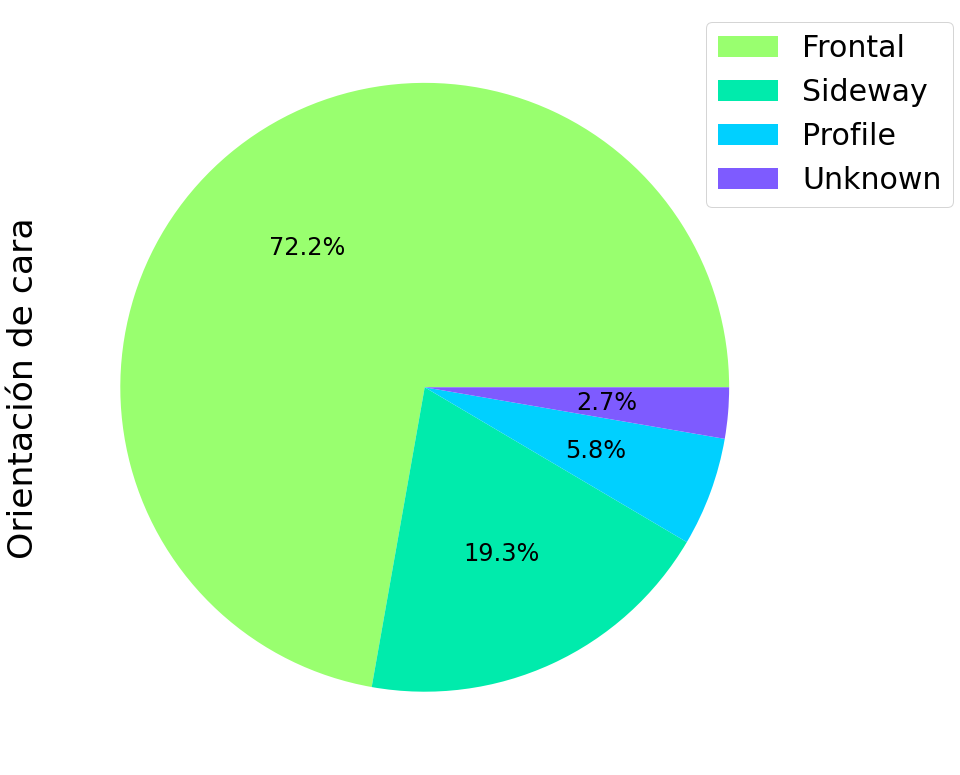

In [10]:
fig1 = dataset_before.orientation.value_counts().plot(kind='pie', subplots=True, labels=None, autopct='%1.1f%%', figsize=(14,14), textprops={'fontsize': 24}, colors=color6, ylabel='Orientación de cara')
plt.legend(bbox_to_anchor=(0.85, 1), loc='upper left', labels=dataset_before.orientation.unique(), fontsize=30)
plt.savefig("plots/orientation_before.png", transparent=True, bbox_inches="tight")

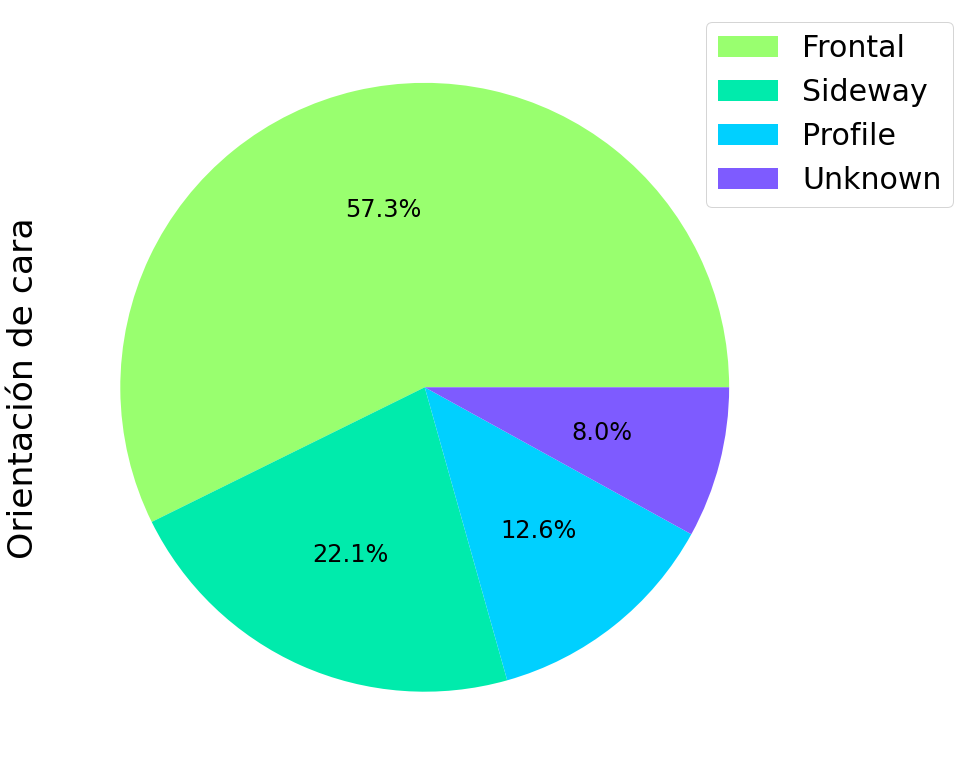

In [11]:
fig1 = dataset.orientation.value_counts().plot(kind='pie', subplots=True, labels=None, autopct='%1.1f%%', figsize=(14,14), textprops={'fontsize': 24}, colors=color6, ylabel='Orientación de cara')
plt.legend(bbox_to_anchor=(0.85, 1), loc='upper left', labels=dataset.orientation.unique(), fontsize=30)
plt.savefig("plots/orientation_after.png", transparent=True, bbox_inches="tight")

Mask              31082
No mask            5029
Mask incorrect      759
Name: label, dtype: int64 36870


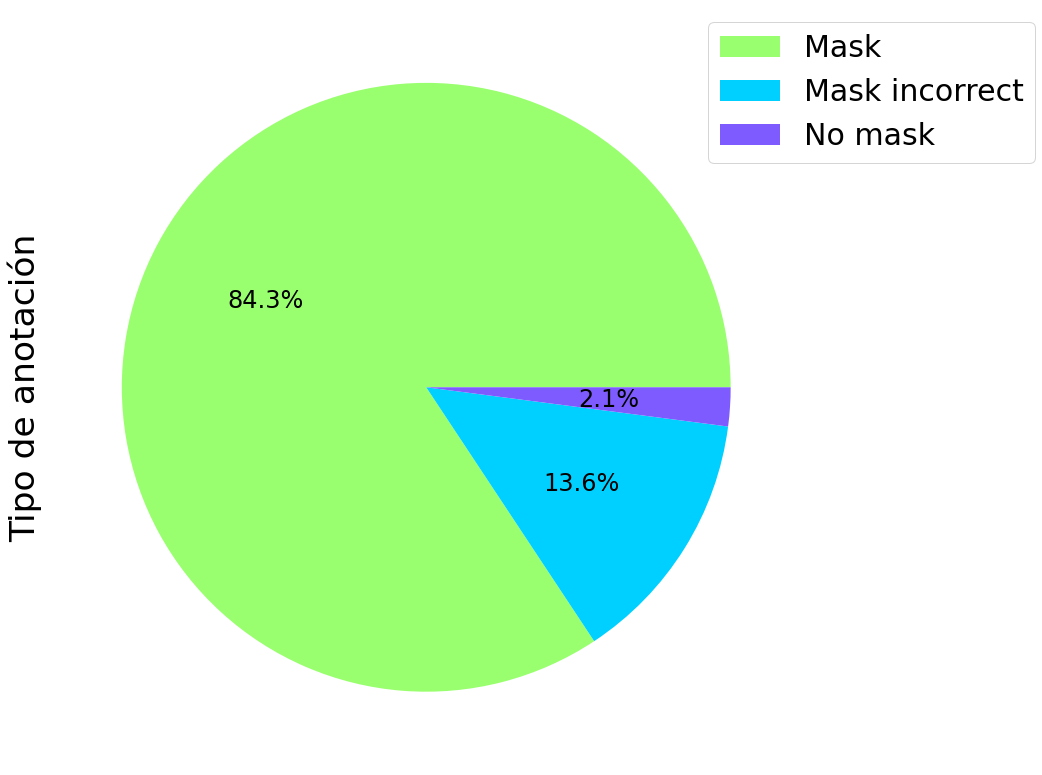

In [12]:
fig2 = dataset_before.label.value_counts().plot(kind='pie', subplots=True, labels=None, autopct='%1.1f%%',figsize=(14,14), textprops={'fontsize': 24}, colors=color3, ylabel='Tipo de anotación')
print(dataset_before.label.value_counts(), len(dataset_before))
plt.legend(bbox_to_anchor=(0.85, 1), loc='upper left', labels=dataset_before.label.unique(), fontsize=30)
plt.savefig("plots/labels_before.png", transparent=True, bbox_inches="tight")


Mask              6634
No mask           5029
Mask incorrect     759
Name: label, dtype: int64 12422


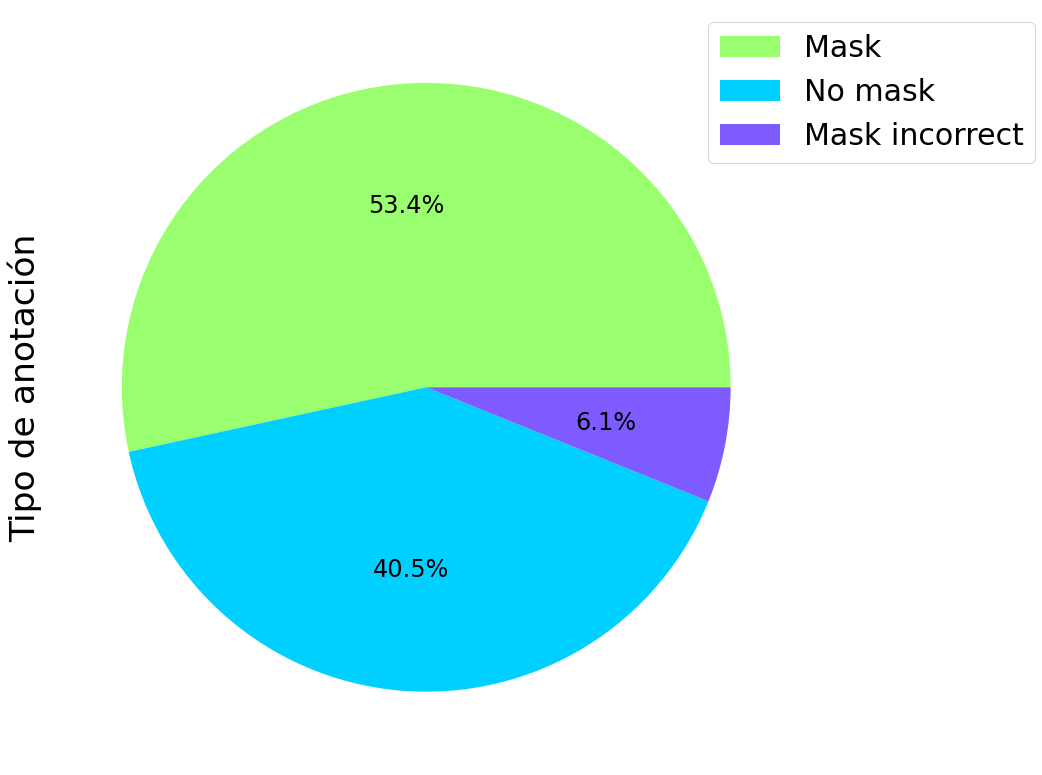

In [13]:
fig2 = dataset.label.value_counts().plot(kind='pie', subplots=True, labels=None, autopct='%1.1f%%',figsize=(14,14), textprops={'fontsize': 24}, colors=color3, ylabel='Tipo de anotación')
print(dataset.label.value_counts(), len(dataset))

plt.legend(bbox_to_anchor=(0.85, 1), loc='upper left', labels=dataset.label.unique(), fontsize=30)
plt.savefig("plots/labels_after.png", transparent=True, bbox_inches="tight")

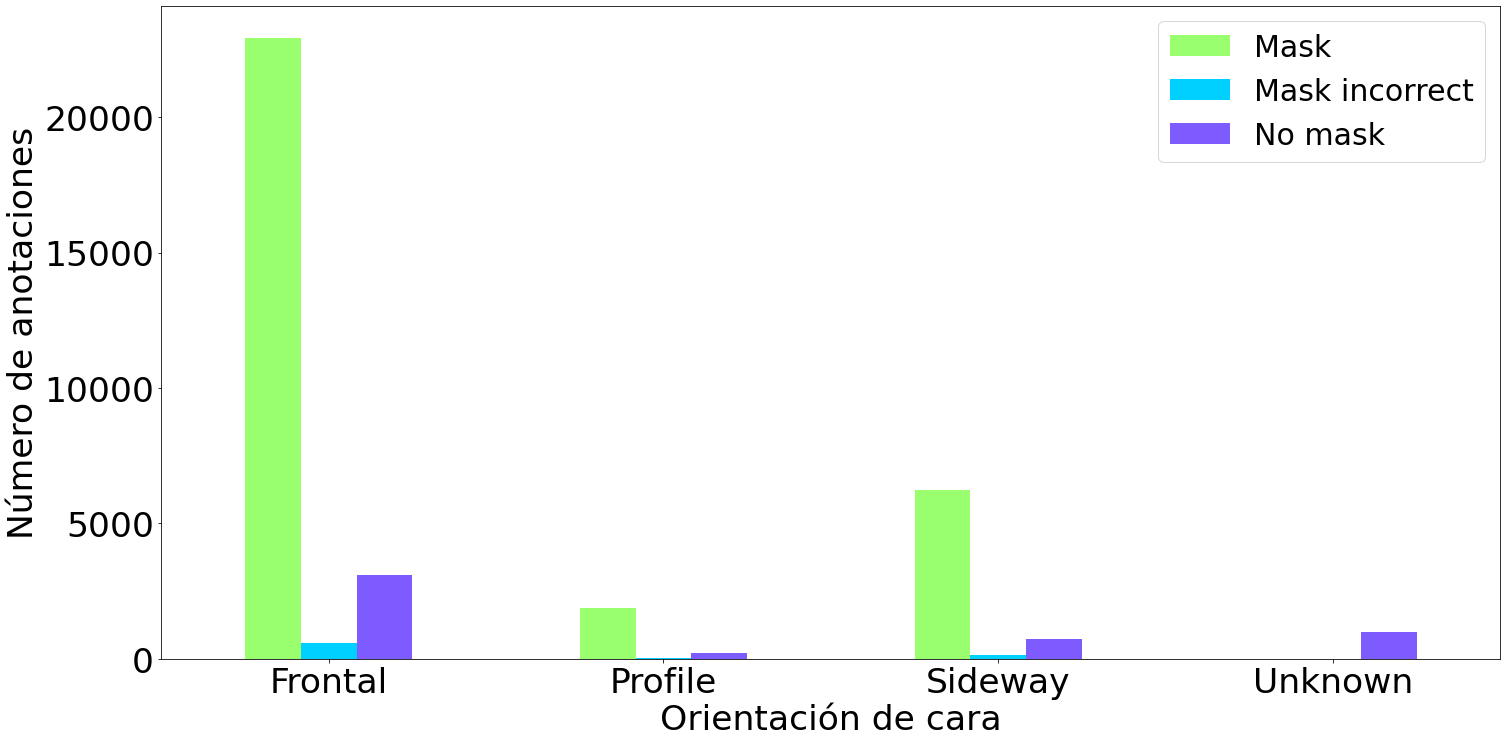

In [14]:
plot = dataset_before.groupby(['orientation','label']).size().unstack().plot(kind='bar', rot=0, xlabel='Orientación de cara', ylabel='Número de anotaciones', figsize=(24,12), color=color3)
plot.legend(loc=1, prop={'size': 30})
plt.savefig("plots/dataset_before.png", transparent=True, bbox_inches="tight")

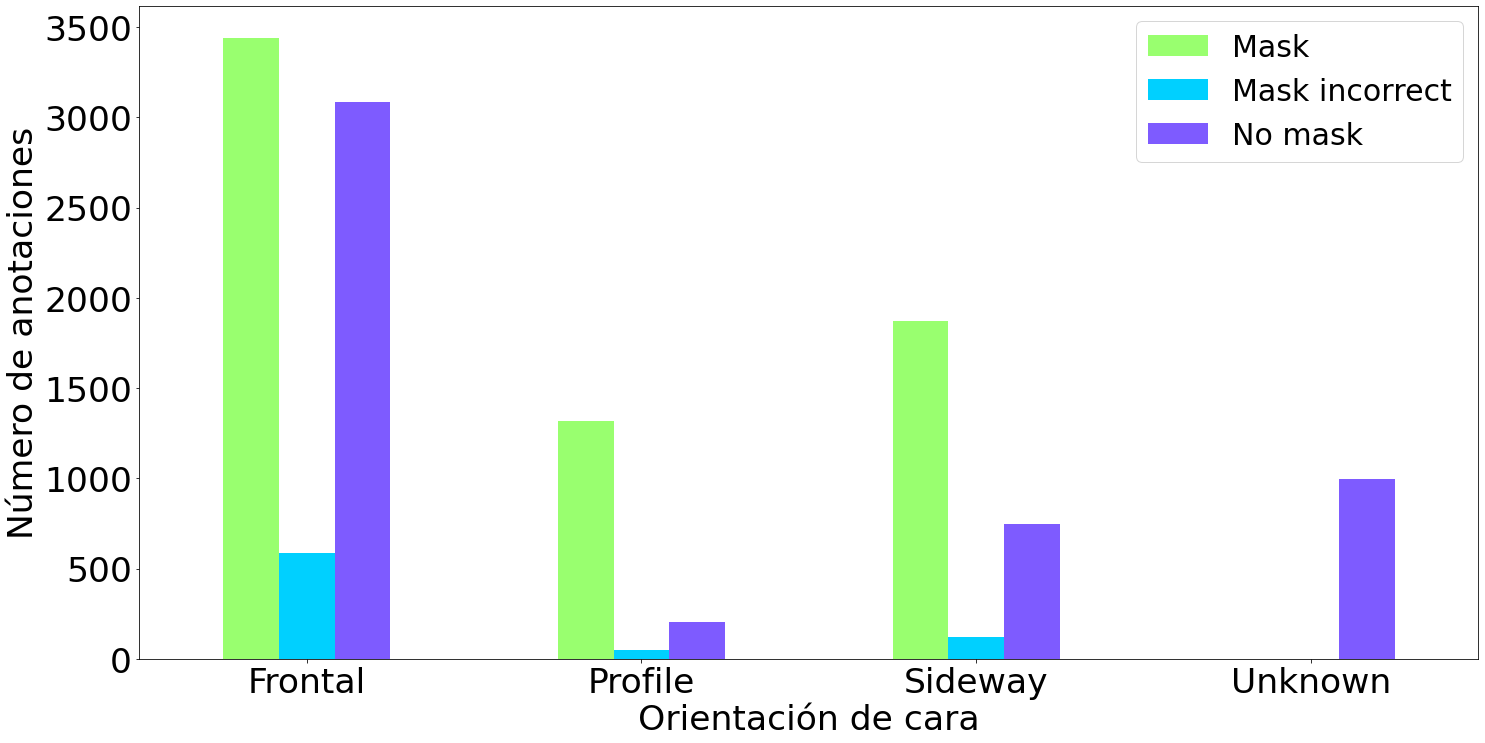

In [15]:
plot = dataset.groupby(['orientation','label']).size().unstack().plot(kind='bar', rot=0, xlabel='Orientación de cara', ylabel='Número de anotaciones', figsize=(24,12), color=color3)
plot.legend(loc=1, prop={'size': 30})
plt.savefig("plots/dataset_after.png", transparent=True, bbox_inches="tight")

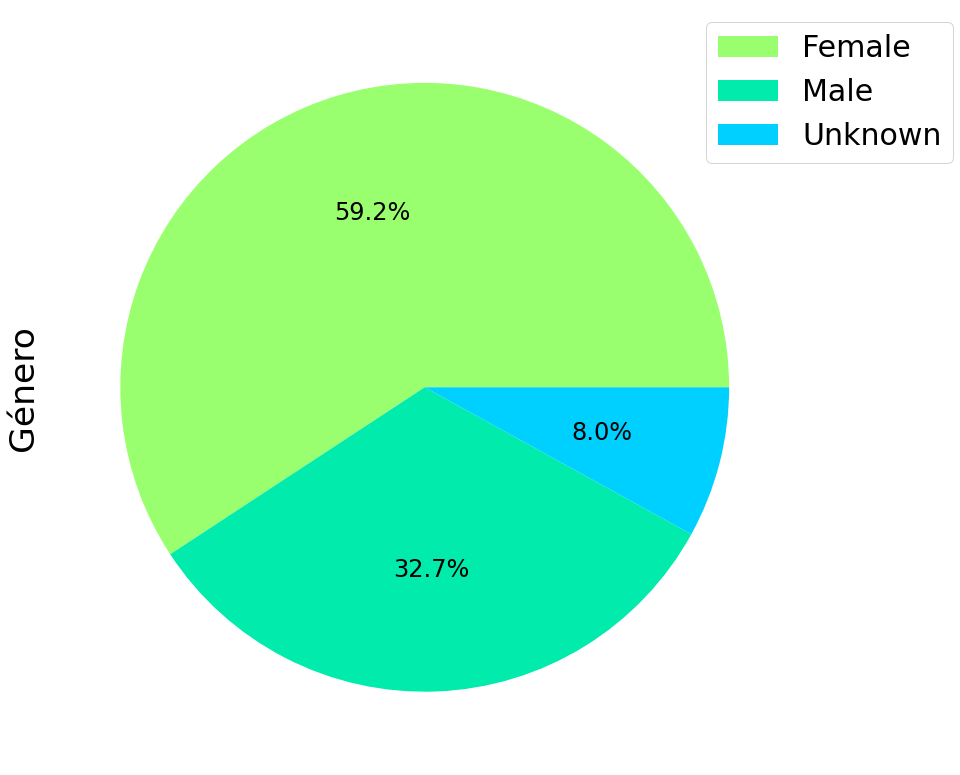

In [16]:
fig1 = dataset.gender.value_counts().plot(kind='pie', subplots=True, labels=None, autopct='%1.1f%%', figsize=(14,14), textprops={'fontsize': 24}, colors=color6, ylabel='Género')
plt.legend(bbox_to_anchor=(0.85, 1), loc='upper left', labels=dataset.gender.unique(), fontsize=30)
plt.savefig("plots/genero.png", transparent=True, bbox_inches="tight")

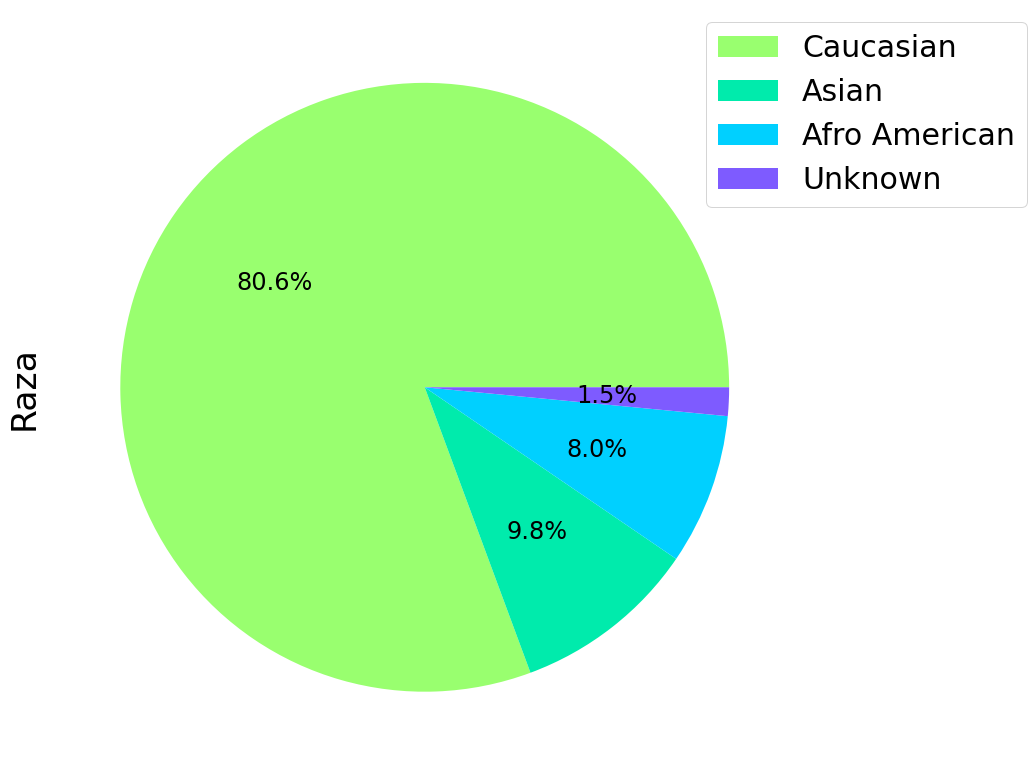

In [17]:
fig1 = dataset.race.value_counts().plot(kind='pie', subplots=True, labels=None, autopct='%1.1f%%', figsize=(14,14), textprops={'fontsize': 24}, colors=color6, ylabel='Raza')
plt.legend(bbox_to_anchor=(0.85, 1), loc='upper left', labels=dataset.race.unique(), fontsize=30)
plt.savefig("plots/raza.png", transparent=True, bbox_inches="tight")

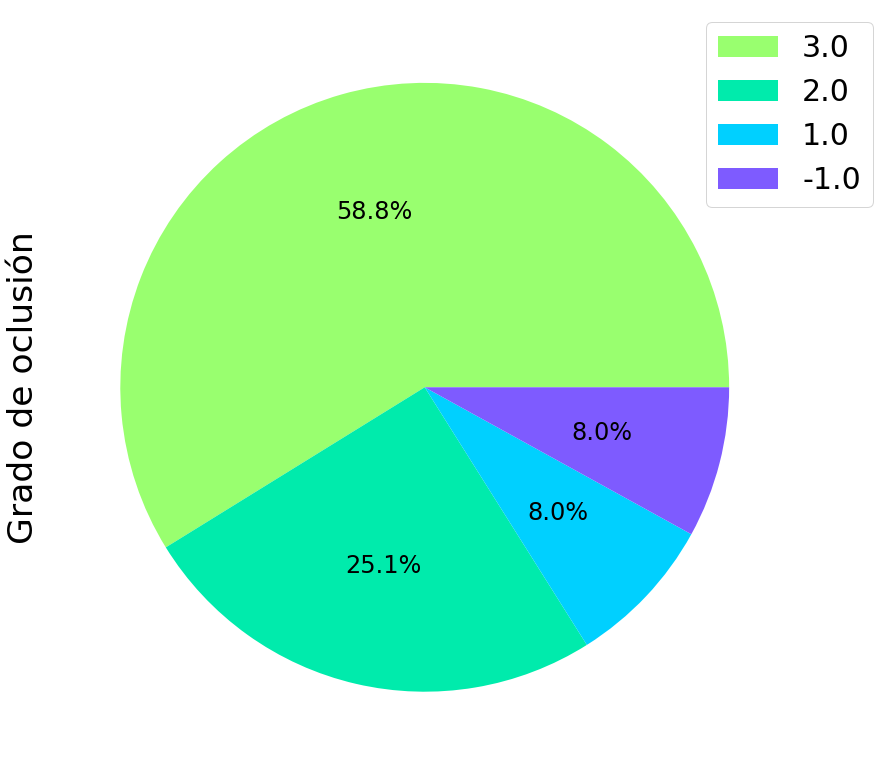

In [18]:
fig1 = dataset.occ_degree.value_counts().plot(kind='pie', subplots=True, labels=None, autopct='%1.1f%%', figsize=(14,14), textprops={'fontsize': 24}, colors=color6, ylabel='Grado de oclusión')
plt.legend(bbox_to_anchor=(0.85, 1), loc='upper left', labels=dataset.occ_degree.unique(), fontsize=30)
plt.savefig("plots/occ_degree.png", transparent=True, bbox_inches="tight")

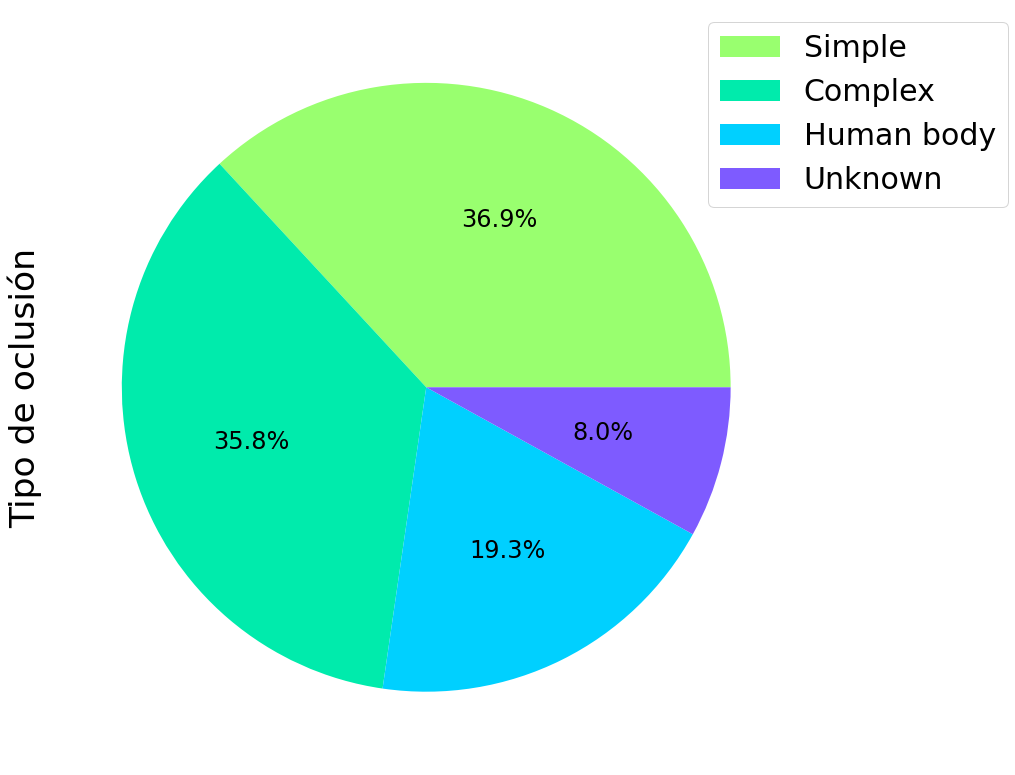

In [19]:
fig1 = dataset.occ_type.value_counts().plot(kind='pie', subplots=True, labels=None, autopct='%1.1f%%', figsize=(14,14), textprops={'fontsize': 24}, colors=color6, ylabel='Tipo de oclusión')
plt.legend(bbox_to_anchor=(0.85, 1), loc='upper left', labels=dataset.occ_type.unique(), fontsize=30)
plt.savefig("plots/occ_dataset.occ_type.png", transparent=True, bbox_inches="tight")

In [20]:
print(dataset.orientation.value_counts())
print(dataset.label.value_counts())

Frontal    7117
Sideway    2742
Profile    1567
Unknown     996
Name: orientation, dtype: int64
Mask              6634
No mask           5029
Mask incorrect     759
Name: label, dtype: int64


# 7 - Dividir las imagenes del dataset final en train, validation y test, con la proporcion 70%, 20%, 10%


In [21]:
# Seleccionar todas las imagenes del dataset
dataset_images = list(set(dataset.image_name.values))
random.shuffle(dataset_images)

train_images = dataset_images[:int(len(dataset_images)*0.7)]
validation_images = dataset_images[int(len(dataset_images)*0.7)+1:int(len(dataset_images)*0.9)]
test_images = dataset_images[int(len(dataset_images)*0.9)+1:]
print(len(train_images))
print(len(validation_images))
print(len(test_images))

print('train')
train=dataset[dataset.image_name.isin(train_images)]
data_check(train)
print('validation')
validation=dataset[dataset.image_name.isin(validation_images)]
data_check(validation)
print('test')
test=dataset[dataset.image_name.isin(test_images)]
data_check(test)

7686
2195
1098
train
Dataset files:  8684
Number of Mask : 4608 / 8684, 53.063105 %
Number of Mask incorrect :  538 / 8684, 6.195302 %
Number of No mask :  3538 / 8684, 40.741594 %
Number of No Mask + Mask incorrect :  4076 / 8684, 46.936895 %
Number of No label:  0 / 8684, 0.000000 %
validation
Dataset files:  2485
Number of Mask : 1340 / 2485, 53.923541 %
Number of Mask incorrect :  151 / 2485, 6.076459 %
Number of No mask :  994 / 2485, 40.000000 %
Number of No Mask + Mask incorrect :  1145 / 2485, 46.076459 %
Number of No label:  0 / 2485, 0.000000 %
test
Dataset files:  1251
Number of Mask : 685 / 1251, 54.756195 %
Number of Mask incorrect :  70 / 1251, 5.595524 %
Number of No mask :  496 / 1251, 39.648281 %
Number of No Mask + Mask incorrect :  566 / 1251, 45.243805 %
Number of No label:  0 / 1251, 0.000000 %


In [22]:
dataset.reset_index(drop=True)

,image_name,x,y,w,h,label,occ_type,occ_degree,gender,race,orientation
0,train_00010343.jpg,136.0,267.0,302.0,302.0,Mask,Simple,3.0,Female,Caucasian,Frontal
1,train_00000172.jpg,130.0,182.0,47.0,47.0,Mask,Simple,3.0,Female,Asian,Frontal
2,train_00022718.jpg,44.0,112.0,237.0,237.0,Mask,Simple,3.0,Female,Asian,Frontal
3,train_00002939.jpg,17.0,2.0,97.0,97.0,Mask,Simple,3.0,Female,Asian,Frontal
4,train_00006145.jpg,60.0,108.0,285.0,285.0,Mask,Simple,3.0,Female,Asian,Frontal
...,...,...,...,...,...,...,...,...,...,...,...
12417,train_00025782.jpg,85.0,78.0,94.0,94.0,Mask incorrect,Simple,2.0,Male,Asian,Frontal
12418,train_00025786.jpg,48.0,53.0,64.0,64.0,Mask incorrect,Simple,2.0,Female,Asian,Frontal
12419,train_00025824.jpg,57.0,21.0,82.0,82.0,Mask incorrect,Simple,2.0,Female,Asian,Frontal
12420,train_00025834.jpg,23.0,26.0,106.0,106.0,Mask incorrect,Simple,2.0,Female,Asian,Sideway


In [23]:
# iterate over dataset rows
split = []
for index, row in dataset.iterrows():
    if row.image_name in train_images:
        split.append('train')
    elif row.image_name in validation_images:
        split.append('validation')
    elif row.image_name in test_images:
        split.append('test')
    else:
        split.append('unknown')
dataset.insert(loc=6,column='split', value=split)

In [24]:
dataset = dataset[dataset['split']!='unknown']
dataset = dataset.reset_index(drop=True)
dataset.head()

,image_name,x,y,w,h,label,split,occ_type,occ_degree,gender,race,orientation
0,train_00010343.jpg,136.0,267.0,302.0,302.0,Mask,train,Simple,3.0,Female,Caucasian,Frontal
1,train_00000172.jpg,130.0,182.0,47.0,47.0,Mask,train,Simple,3.0,Female,Asian,Frontal
2,train_00022718.jpg,44.0,112.0,237.0,237.0,Mask,validation,Simple,3.0,Female,Asian,Frontal
3,train_00002939.jpg,17.0,2.0,97.0,97.0,Mask,validation,Simple,3.0,Female,Asian,Frontal
4,train_00006145.jpg,60.0,108.0,285.0,285.0,Mask,train,Simple,3.0,Female,Asian,Frontal


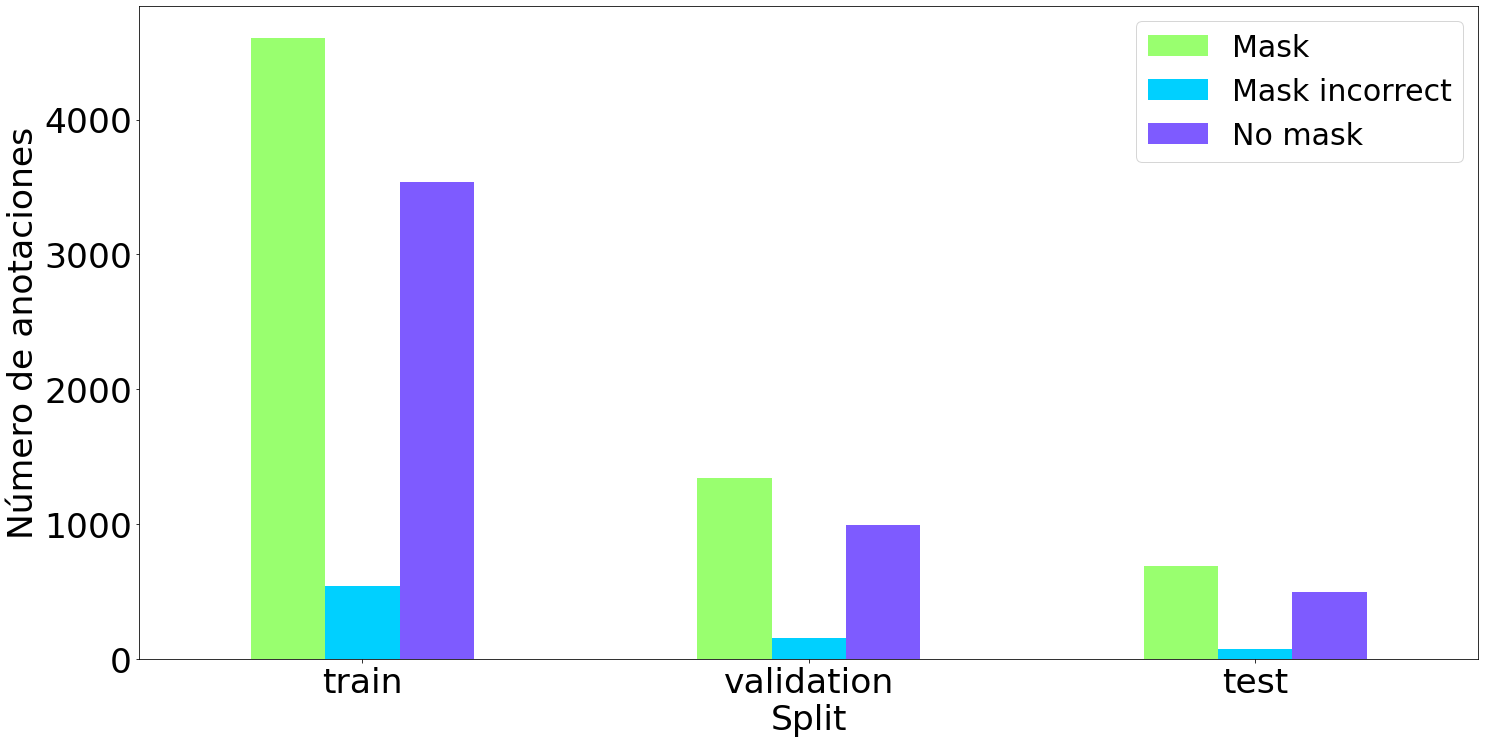

In [25]:
plot =dataset.groupby(['split','label']).size().unstack().reindex(['train', 'validation', 'test']).plot(kind='bar', rot=0, xlabel='Split', ylabel='Número de anotaciones', figsize=(24,12), color=color3)
plot.legend(loc=1, prop={'size': 30})
plot.set_xticklabels(['train', 'validation', 'test'])
plt.savefig("plots/dataset_split.png", transparent=True, bbox_inches="tight")

# 8 - Pasar los dataframe al formato que usa YOLO para las anotaciones 


In [26]:
make_yolo_labels(train, validation, test)

Making yolo labels for training data...
Done
Making yolo labels for validation data...
Image MAFA/test_00001524.jpg doesn't exist.
2865
File not found:  MAFA\test_00001524.jpg
Done
Making yolo labels for test data...
Done


# 9 - Guardar dataframes en csv


In [27]:
dataset.to_csv('csv/dataset.csv', index=False)
train.to_csv('csv/train.csv', index=False)
validation.to_csv('csv/validation.csv', index=False)
test.to_csv('csv/test.csv', index=False)